# Modeling Cross Section Data with KNN, DT, and Random Forest

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
from joblib import dump, load
from matplotlib.ticker import MaxNLocator
import os

In [2]:
import sys
# This allows us to import the nucml utilities
sys.path.append("..")

import nucml.exfor.data_utilities as exfor_utils
import nucml.evaluation.data_utilities as endf_utils
import nucml.plot.utilities as plot_utils
import nucml.datasets as nuc_data
import nucml.ace.data_utilities as ace_utils
import nucml.model.building_utils as model_build
import nucml.model.utilities as model_utils
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
importlib.reload(nuc_data)
importlib.reload(ace_utils)
importlib.reload(model_build)
importlib.reload(model_utils)
print("Finish importing scripts.")

Finish importing scripts.


In [3]:
figure_dir = "Figures/"

In [4]:
sns.set(font_scale=2.5)
sns.set_style('white')

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
import plotly.express as px

# Loading Normalized One-Hot Encoded Training, Validation, and Testing Datasets

In [7]:
df_b0, _, _, _, _, to_scale_b0, _ = nuc_data.load_exfor(pedro=True, basic=0, normalize=False)
df_b2, _, _, _, _, to_scale_b2, _ = nuc_data.load_exfor(pedro=True, basic=2)

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: True
INFO:root: LOG: True
INFO:root: BASIC: 0
INFO:root:Reading data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/EXFOR/CSV_Files\EXFOR_neutrons/EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4184115, 8)
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.
INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: True
INFO:root: LOG: True
INFO:root: BASIC: 2
INFO:root:Reading data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/EXFOR/CSV_Files\EXFOR_neutrons/EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4184115, 18)
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.


In [9]:
df = nuc_data.load_exfor(basic=0, low_en=True, filters=True)

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: True
INFO:root: LOG: False
INFO:root: BASIC: 0
INFO:root:Reading data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/EXFOR/CSV_Files\EXFOR_neutrons/EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4184115, 8)
INFO:root:Finished. Resulting dataset has shape (4184115, 8)


In [18]:
df_norm, x_train, x_test, y_train, y_test, to_scale, scaler = nuc_data.load_exfor(
    log=True, basic=0, num=True, low_en=True, filters=True)

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: True
INFO:root: LOG: True
INFO:root: BASIC: 0
INFO:root: SCALER: STANDARD
INFO:root:Reading data from C:\Users\Pedro\Desktop\ML_Nuclear_Data\EXFOR\CSV_Files\EXFOR_neutrons\EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4184115, 10)
INFO:root:Dropping unnecessary features and one-hot encoding categorical columns...
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.


In [11]:
df = df.drop(columns=["dEnergy", "dData"])

# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [32]:
endf_cl = nuc_data.load_evaluation("Cl035", 103, log=True)

INFO:root:EVALUATION: Extracting data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/Evaluated_Data\neutrons/Cl035/endfb8.0/tables/xs/n-Cl035-MT103.endfb8.0
INFO:root:EVALUATION: Converting MeV to eV...
INFO:root:EVALUATION: Converting mb to b...
INFO:root:EVALUATION: Finished. ENDF data contains 8791 datapoints.


# Importing Error Metrics and Loading ACE Energy Arrays

In [33]:
ace_cl = ace_utils.get_energies("17035", ev=True, log=True)

# Getting best KNN Models

In [9]:
knn_results = pd.read_csv("1_KNN/knn_results_B2.csv").sort_values(by="id")
best_knn = model_utils.get_best_models_df(knn_results, keep_first=True)
best_knn

,id,distance_metric,mt_strategy,normalizer,train_mae,train_mse,train_evs,train_mae_m,train_r2,val_mae,...,test_mae,test_mse,test_evs,test_mae_m,test_r2,model_path,training_time,scaler_path,run_name,tag
19,20,manhattan,one_hot,minmax,0.025820,0.010877,0.985897,0.0,0.985897,0.117205,...,0.116502,0.059456,0.919866,0.042790,0.919864,E:\ML_Models_EXFOR\KNN_B2\k20_distance_manhatt...,11610.134845,E:\ML_Models_EXFOR\KNN_B2\k20_distance_manhatt...,k20_distance_manhattan_minmax_one_hot_B2_v1,Train
8,11,manhattan,one_hot,minmax,0.025873,0.010936,0.985819,0.0,0.985819,0.115434,...,0.115954,0.061345,0.918705,0.040778,0.918705,E:\ML_Models_EXFOR\KNN_B2\k11_distance_manhatt...,9453.814605,E:\ML_Models_EXFOR\KNN_B2\k11_distance_manhatt...,k11_distance_manhattan_minmax_one_hot_B2_v1,Val
0,13,manhattan,one_hot,minmax,0.025877,0.010921,0.985853,0.0,0.985853,0.116044,...,0.115255,0.060093,0.919002,0.041119,0.919002,E:\ML_Models_EXFOR\KNN_B2\k13_distance_manhatt...,6122.514390,E:\ML_Models_EXFOR\KNN_B2\k13_distance_manhatt...,k13_distance_manhattan_minmax_one_hot_B2_v1,Test


In [12]:
knn_train_model, knn_train_scaler = model_utils.load_model_and_scaler(best_knn.iloc[[0]])

In [10]:
# knn_results = pd.read_csv("1_KNN/KNN_B0/knn_results.csv").sort_values(by="id")
# knn_results["Model"] = knn_results.model_path.apply(lambda x: os.path.basename(os.path.dirname(x)))
# best_knn = model_utils.get_best_models_df(knn_results)
# best_knn

In [13]:
# best_handicked = knn_results[knn_results.Model == "k10_distance_euclidean_robust_one_hot_B0_v4"]

# best_handicked.training_time / 60 / 60 # hours

# knn_train_model, knn_train_scaler = model_utils.load_model_and_scaler(best_knn.iloc[[0]])
# knn_val_model, knn_val_scaler = model_utils.load_model_and_scaler(best_knn.iloc[[1]])
# knn_test_model, knn_test_scaler = model_utils.load_model_and_scaler(best_knn.iloc[[2]])
# knn_handpicked_model, knn_handpicked_scaler = model_utils.load_model_and_scaler(best_handicked)

# Getting best DT Models

In [15]:
dt_results = pd.read_csv("2_DT/dt_resultsB0.csv").sort_values(by="max_depth")
dt_results = dt_results[dt_results.normalizer == "none"]

best_dt = model_utils.get_best_models_df(dt_results, keep_first=True)
best_dt

,id,max_depth,mss,msl,mt_strategy,normalizer,train_mae,train_mse,train_evs,train_mae_m,...,val_r2,test_mae,test_mse,test_evs,test_mae_m,test_r2,model_path,training_time,scaler_path,tag
369,681,400,2,1,one_hot,none,0.025773,0.010789,0.985999,0.000000,...,0.894051,0.135027,0.081226,0.895526,0.047396,0.895523,E:\ML_Models_EXFOR\DT_B0\DT400_MSS2_MSL1_none_...,109.273998,E:\ML_Models_EXFOR\DT_B0\DT400_MSS2_MSL1_none_...,Train
376,494,84,10,7,one_hot,none,0.094411,0.037966,0.948927,0.035953,...,0.923212,0.119076,0.057716,0.922230,0.046595,0.922230,E:\ML_Models_EXFOR\DT_B0\DT84_MSS10_MSL7_none_...,37.965002,E:\ML_Models_EXFOR\DT_B0\DT84_MSS10_MSL7_none_...,Val
99,74,90,10,7,one_hot,none,0.094439,0.038053,0.948807,0.035948,...,0.921833,0.118706,0.057551,0.922877,0.046615,0.922877,E:\ML_Models_EXFOR\DT_B0\DT90_MSS10_MSL7_none_...,34.589237,E:\ML_Models_EXFOR\DT_B0\DT90_MSS10_MSL7_none_...,Test


In [26]:
dt_train_model = model_utils.load_model_and_scaler(best_dt.iloc[[0]], model_only=True)

In [17]:
# best_handicked_dt = dt_results[dt_results.Model == "DT100_MSS15_MSL7_standard_one_hot_B0_v5"]

# (dt_results.training_time.sum() + knn_results.training_time.sum()) / 60 / 60 /60

# dt_train_model, dt_train_scaler = model_utils.load_model_and_scaler(best_dt.iloc[[0]])
# dt_val_model, dt_val_scaler = model_utils.load_model_and_scaler(best_dt.iloc[[1]])
# dt_test_model, dt_test_scaler = model_utils.load_model_and_scaler(best_dt.iloc[[2]])
# dt_handpicked_model, dt_handpicked_scaler = model_utils.load_model_and_scaler(best_handicked_dt)

# Sampling Chlorine (n,p) and U-233(n,f) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [18]:
# kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "to_scale": to_scale}

# chlorine_35_np_knn = exfor_utils.load_samples(df, 17, 35, "MT_103", scaler=knn_handpicked_scaler, **kwargs)
#chlorine_35_np_dt = exfor_utils.load_samples(df, 17, 35, "MT_103", scaler=dt_handpicked_scaler, **kwargs)

In [28]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": False, "to_scale": None}

# chlorine_35_np_knn = exfor_utils.load_samples(df, 17, 35, "MT_103", scaler=knn_handpicked_scaler, **kwargs)
chlorine_35_np_dt = exfor_utils.load_samples(df_b0, 17, 35, 103, scaler=None, **kwargs)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (215, 40)


# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

In [68]:
new_cl_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":True, "one_hot":True}
new_cl_data_knn = exfor_utils.load_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df_b2, 
                                          scaler=knn_train_scaler, to_scale=to_scale_b2, **new_cl_data_kwargs)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (215, 50)
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (12, 50)


In [24]:
new_cl_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":False, "one_hot":True}
new_cl_data_dt = exfor_utils.load_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df_b0, **new_cl_data_kwargs)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (215, 40)
INFO:root:EXFOR extracted DataFrame has shape: (12, 40)


In [25]:
# new_cl_data_kwargs = {"Z":17, "A":35, "MT":"MT_103", "log":True, "scale":True, "to_scale":to_scale, "one_hot":True}
# new_cl_data_knn = exfor_utils.load_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, scaler=knn_handpicked_scaler, **new_cl_data_kwargs)
# new_cl_data_dt = exfor_utils.load_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, scaler=dt_handpicked_scaler, **new_cl_data_kwargs)
# new_cl_data_dt.head()

# Nearest Neighbors Regression

In [53]:
# def make_chlorine_paper_figure(df, dt_model, dt_scaler, knn_model, knn_scaler, to_scale, endf_cl, e_array, saving_dir=None):
    
#     fig, (ax1, ax2) = plt.subplots(2, figsize=(30,20))

#     dt_kwargs = {"nat_iso": "I", "one_hot": True, "scale": False, "to_scale": None}
#     knn_kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "to_scale": to_scale}
#     chlorine_data_dt = exfor_utils.load_samples(df, 17, 35, 103, scaler=None, **dt_kwargs)
#     chlorine_data_knn = exfor_utils.load_samples(df, 17, 35, 103, scaler=knn_scaler, **knn_kwargs)
    
    
#     new_cl_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":True, "to_scale":to_scale, "one_hot":True}
#     new_data_knn = exfor_utils.load_newdata(
#         "../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, scaler=knn_scaler, **new_cl_data_kwargs)
#     new_data_dt = exfor_utils.load_newdata(
#         "../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, scaler=dt_scaler, **new_cl_data_kwargs)
    
#     new_cl_knn_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":True, "one_hot":True}
#     new_cl_dt_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":False, "one_hot":True}

#     chlorine_data_ext = exfor_utils.expanding_dataset_energy(chlorine_data_dt, 0, 0, False, 0, e_array=e_array)
#     chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_dt.Energy.min()]
    
#     ax1.plot(10**(chlorine_data_ext.Energy), 10**(dt_model.predict(chlorine_data_ext.drop(columns=["Data"]))), label="DT", linestyle="dashed", c="firebrick", linewidth=3)
#     ax1.scatter(10**(chlorine_data_dt.Energy), 10**(chlorine_data_dt.Data), alpha=0.5, c='#1f77b4', label="EXFOR")
#     ax1.scatter(10**(new_data_dt.Energy), 10**(new_data_dt.Data), alpha=1, c='#ff7f0e', s=250, marker="x", label="J.C.Batchelder (2019)")
#     ax1.plot(10**(endf_cl.Energy), 10**(endf_cl.Data), alpha=0.5, c="orange", label="ENDF")
#     ax1.legend(loc=3)

#     chlorine_data_ext = exfor_utils.expanding_dataset_energy(chlorine_data_knn, 0, 0, False, 0, e_array=e_array)
#     chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_knn.Energy.min()]
    
#     ax2.plot(10**(chlorine_data_ext.Energy), 10**(knn_model.predict(chlorine_data_ext.drop(columns=["Data"]))), label="KNN", linestyle="dashed", c="firebrick", linewidth=3)
#     ax2.scatter(10**(chlorine_data_knn.Energy), 10**(chlorine_data_knn.Data), alpha=0.5, c='#1f77b4', label="EXFOR")
#     ax2.scatter(10**(new_data_knn.Energy), 10**(new_data_knn.Data), alpha=1, s=250, c='#ff7f0e', marker="x", label="J.C.Batchelder (2019)")
#     ax2.plot(10**(endf_cl.Energy), 10**(endf_cl.Data), alpha=0.5, c="orange", label="ENDF")
#     ax2.legend(loc=3)

#     ax1.set(ylabel='Cross Section (b)')
#     ax2.set(ylabel='Cross Section (b)')
    
#     ax1.set(xlabel='Energy (eV)') 
#     ax2.set(xlabel='Energy (eV)') 
    
#     ax1.set_xscale('log')
#     ax2.set_xscale('log')
#     ax2.set_yscale('log')
#     ax1.set_yscale('log')
#     ax1.set_xlim(10**-2, 10**7.5)
#     ax2.set_xlim(10**-2, 10**7.5)

# #     fig.text(0.5, 0.04, 'Energy (eV)', ha='center')
# #     fig.text(0.04, 0.5, 'Cross Section (b)', va='center', rotation='vertical')
# #     # plt.tight_layout()
# #     plt.tight_layout(w_pad=5.5, h_pad=5.0)
    
#     plt.savefig(os.path.join(saving_dir, "ML_Cl.png"), dpi=600, bbox_inches="tight")

# make_chlorine_paper_figure(df, dt_train_model, dt_train_scaler, knn_train_model, knn_train_scaler,
#                            to_scale_b2, endf_cl, ace_cl, saving_dir=figure_dir)

In [69]:
def make_chlorine_paper_figure(df_knn, df_dt, dt_model, knn_model, knn_scaler, to_scale, endf_cl, e_array, saving_dir=None):
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(30,20))

    dt_kwargs = {"nat_iso": "I", "one_hot": True, "scale": False, "to_scale": None}
    knn_kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "to_scale": to_scale}
    chlorine_data_dt = exfor_utils.load_samples(df_dt, 17, 35, 103, scaler=None, **dt_kwargs)
    chlorine_data_knn = exfor_utils.load_samples(df_knn, 17, 35, 103, scaler=knn_scaler, **knn_kwargs)
    
    new_cl_knn_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":True, "one_hot":True}
    new_cl_dt_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":False, "one_hot":True}
    
    new_data_knn = exfor_utils.load_newdata(
        "../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df_knn, scaler=knn_scaler, to_scale=to_scale, **new_cl_knn_data_kwargs)
    
    new_data_dt = exfor_utils.load_newdata(
        "../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df_dt, scaler=None, **new_cl_dt_data_kwargs)
    
    chlorine_data_ext = exfor_utils.expanding_dataset_energy(chlorine_data_dt, 0, 0, False, 0, e_array=e_array)
    chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_dt.Energy.min()]
    
    ax1.plot(10**(chlorine_data_ext.Energy), 10**(dt_model.predict(chlorine_data_ext.drop(columns=["Data"]))), label="DT", linestyle="dashed", c="firebrick", linewidth=3)
    ax1.scatter(10**(chlorine_data_dt.Energy), 10**(chlorine_data_dt.Data), alpha=0.5, c='#1f77b4', label="EXFOR")
    ax1.scatter(10**(new_data_dt.Energy), 10**(new_data_dt.Data), alpha=1, c='#ff7f0e', s=250, marker="x", label="J.C.Batchelder (2019)")
    ax1.plot(10**(endf_cl.Energy), 10**(endf_cl.Data), alpha=0.5, c="orange", label="ENDF")
    ax1.legend(loc=3)

    chlorine_data_ext = exfor_utils.expanding_dataset_energy(chlorine_data_knn, 0, 0, False, 0, e_array=e_array)
    chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_knn.Energy.min()]
    
    ax2.plot(10**(chlorine_data_ext.Energy), 10**(knn_model.predict(chlorine_data_ext.drop(columns=["Data"]))), label="KNN", linestyle="dashed", c="firebrick", linewidth=3)
    ax2.scatter(10**(chlorine_data_knn.Energy), 10**(chlorine_data_knn.Data), alpha=0.5, c='#1f77b4', label="EXFOR")
    ax2.scatter(10**(new_data_knn.Energy), 10**(new_data_knn.Data), alpha=1, s=250, c='#ff7f0e', marker="x", label="J.C.Batchelder (2019)")
    ax2.plot(10**(endf_cl.Energy), 10**(endf_cl.Data), alpha=0.5, c="orange", label="ENDF")
    ax2.legend(loc=3)

    ax1.set(ylabel='Cross Section (b)')
    ax2.set(ylabel='Cross Section (b)')
    
    ax1.set(xlabel='Energy (eV)') 
    ax2.set(xlabel='Energy (eV)') 
    
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(10**-2, 10**7.5)
    ax2.set_xlim(10**-2, 10**7.5)

#     fig.text(0.5, 0.04, 'Energy (eV)', ha='center')
#     fig.text(0.04, 0.5, 'Cross Section (b)', va='center', rotation='vertical')
#     # plt.tight_layout()
#     plt.tight_layout(w_pad=5.5, h_pad=5.0)
    
    plt.savefig(os.path.join(saving_dir, "ML_Cl.png"), dpi=600, bbox_inches="tight")

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (215, 40)
INFO:root:Extracting samples from dataframe.
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (215, 50)
INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (215, 50)
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (12, 50)
INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (215, 40)
INFO:root:EXFOR extracted DataFrame has shape: (12, 40)


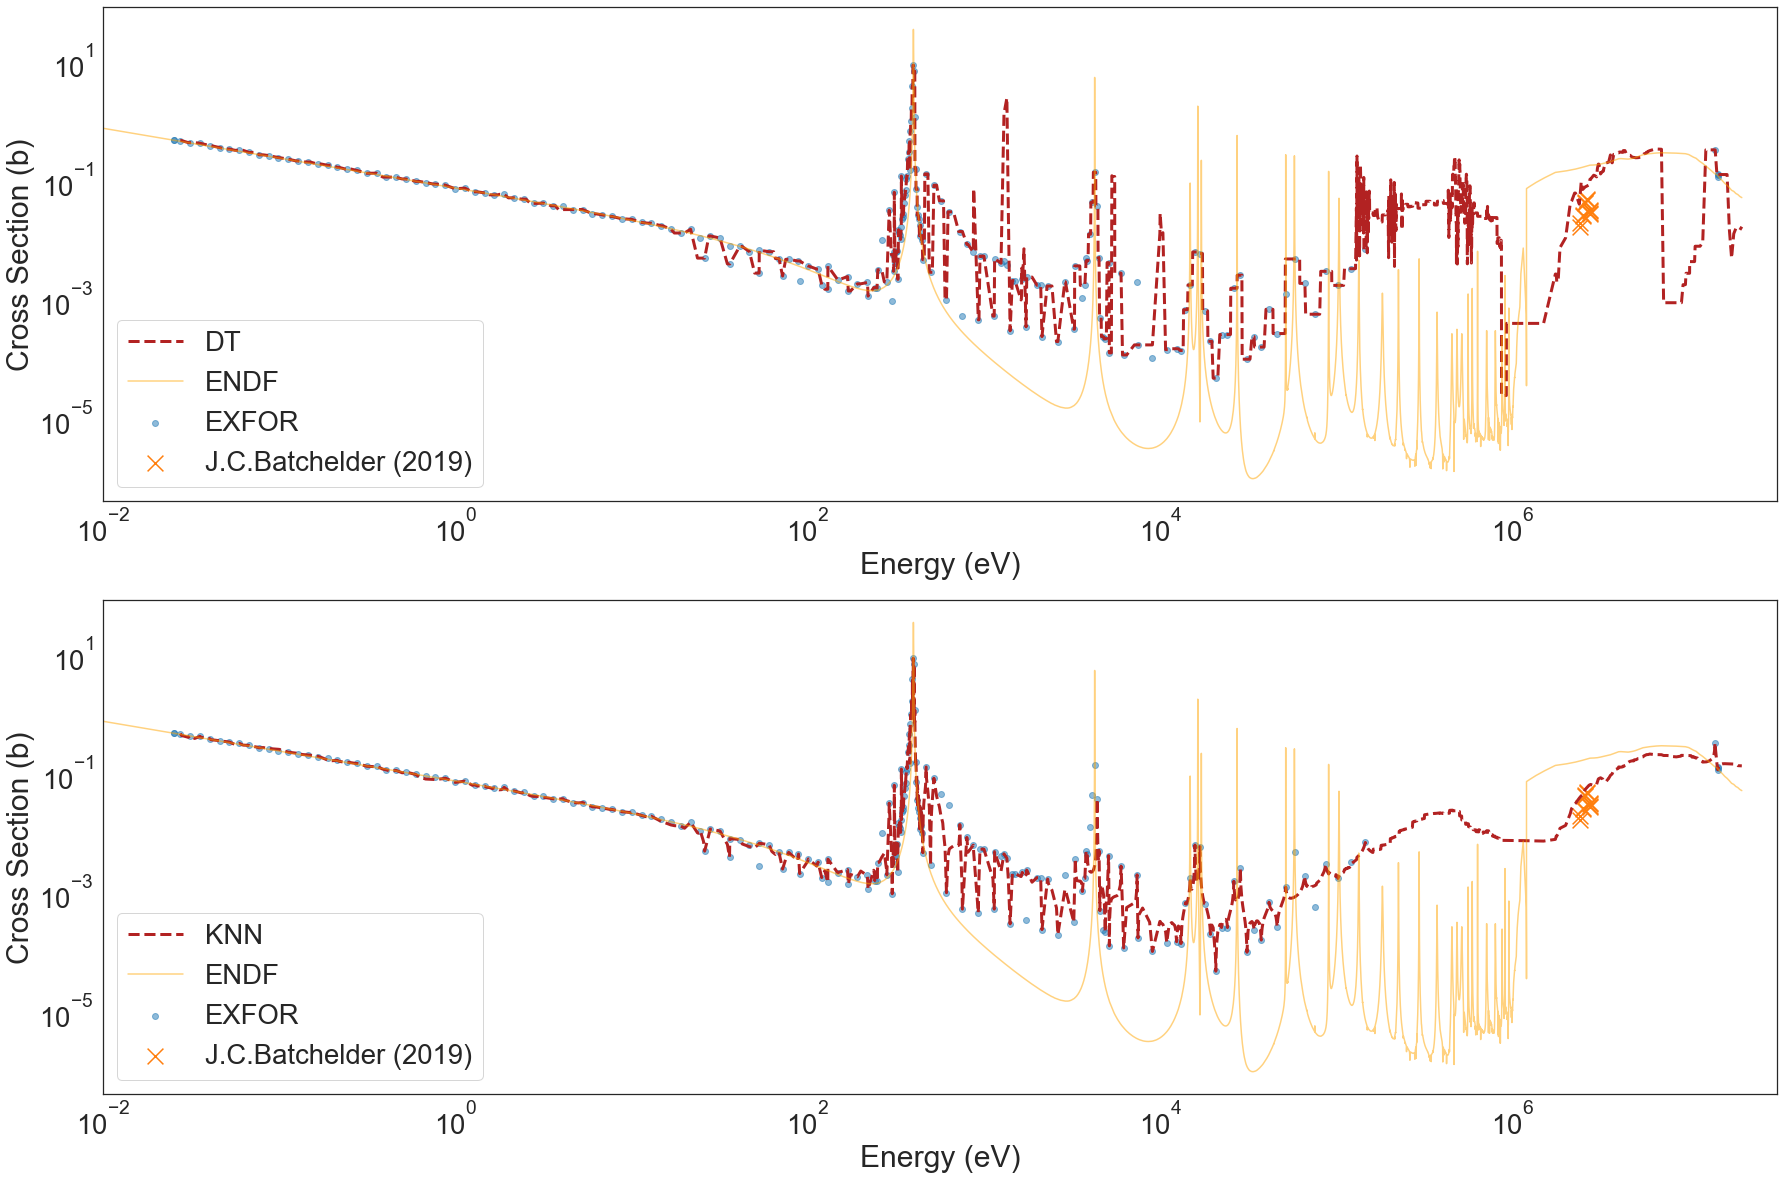

In [70]:
make_chlorine_paper_figure(df_b2, df_b0, dt_train_model, knn_train_model, knn_train_scaler, to_scale_b2, endf_cl, ace_cl, saving_dir=figure_dir)

In [71]:
new_cl_data_dt

,Energy,Data,Z,N,A,MT_1,MT_101,MT_102,MT_103,MT_104,...,MT_33,MT_4,MT_41,MT_51,MT_9000,MT_9001,Center_of_Mass_Flag_Center_of_Mass,Center_of_Mass_Flag_Lab,Element_Flag_I,Element_Flag_N
0,6.383815,-1.779892,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
1,6.383815,-1.707744,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
2,6.401401,-1.583359,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
3,6.401401,-1.590067,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
4,6.411620,-1.350665,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
5,6.411620,-1.379864,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
6,6.421604,-1.301030,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
7,6.421604,-1.320572,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
8,6.437751,-1.546682,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
9,6.437751,-1.551294,17,18,35,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [72]:
dt_train_model.predict(new_cl_data_dt.drop(columns=["Data"]))

array([-1.39469495, -1.39469495, -1.04095861, -1.04095861, -1.10619893,
       -1.10619893, -1.15490196, -1.15490196, -1.06917306, -1.06917306,
       -1.06917306, -1.06917306])

In [73]:
for_latex = pd.DataFrame(columns=["Energy", "Data", "DT", "KNN"])

In [78]:
for_latex["Energy"] = 10**new_cl_data_dt.Energy.values
for_latex["Data"] = 10**new_cl_data_dt.Data.values
for_latex["DT"] = 10**dt_train_model.predict(new_cl_data_dt.drop(columns=["Data"]))
for_latex["KNN"] = 10**knn_train_model.predict(new_cl_data_knn.drop(columns=["Data"]))

In [79]:
print(for_latex.to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
   Energy &   Data &       DT &      KNN \\
\midrule
2420000.0 & 0.0166 & 0.040300 & 0.040723 \\
2420000.0 & 0.0196 & 0.040300 & 0.040723 \\
2520000.0 & 0.0261 & 0.091000 & 0.045894 \\
2520000.0 & 0.0257 & 0.091000 & 0.045894 \\
2580000.0 & 0.0446 & 0.078307 & 0.054121 \\
2580000.0 & 0.0417 & 0.078307 & 0.054121 \\
2640000.0 & 0.0500 & 0.070000 & 0.059396 \\
2640000.0 & 0.0478 & 0.070000 & 0.059396 \\
2740000.0 & 0.0284 & 0.085276 & 0.064900 \\
2740000.0 & 0.0281 & 0.085276 & 0.064900 \\
2740000.0 & 0.0315 & 0.085276 & 0.064900 \\
2740000.0 & 0.0324 & 0.085276 & 0.064900 \\
\bottomrule
\end{tabular}



In [83]:
for_latex[["DT", "KNN"]].drop_duplicates().mean()

DT     0.072977
KNN    0.053007
dtype: float64

In [76]:
10**new_cl_data_dt.Data.values

array([0.0166, 0.0196, 0.0261, 0.0257, 0.0446, 0.0417, 0.05  , 0.0478,
       0.0284, 0.0281, 0.0315, 0.0324])

In [77]:
10**new_cl_data_dt.Data.values - 10**dt_handpicked_model.predict(new_cl_data_dt.drop(columns=["Data"]))

NameError: name 'dt_handpicked_model' is not defined

In [57]:
10**new_cl_data_knn.Data.values - 10**knn_handpicked_model.predict(new_cl_data_knn.drop(columns=["Data"]))

array([-0.05143934, -0.04843934, -0.04759795, -0.04799795, -0.03760033,
       -0.04050033, -0.03499623, -0.03719623, -0.07311504, -0.07341504,
       -0.07001504, -0.06911504])

In [63]:
results = pd.read_csv("ML_CL_RESULTS.csv")

In [66]:
import sklearn.metrics as metrics

In [70]:
metrics.median_absolute_error(results.Data, results.JENDL)

0.145688

In [64]:
results

,Energy,Data,DT,KNN,ENDF,JENDL
0,2420000.0,0.0196,0.057413,0.048439,0.162609,0.165603
1,2520000.0,0.0261,0.050913,0.047598,0.162724,0.171788
2,2580000.0,0.0446,0.032413,0.037600,0.165948,0.173959
3,2640000.0,0.0500,0.027013,0.034996,0.168482,0.176129
4,2740000.0,0.0315,0.080433,0.070015,0.169618,0.178300


INFO:root:Extracting samples from dataframe.
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (215, 40)
INFO:root:Extracting samples from dataframe.
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (215, 40)
INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (215, 40)
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (12, 40)
INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (215, 40)
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (12, 40)


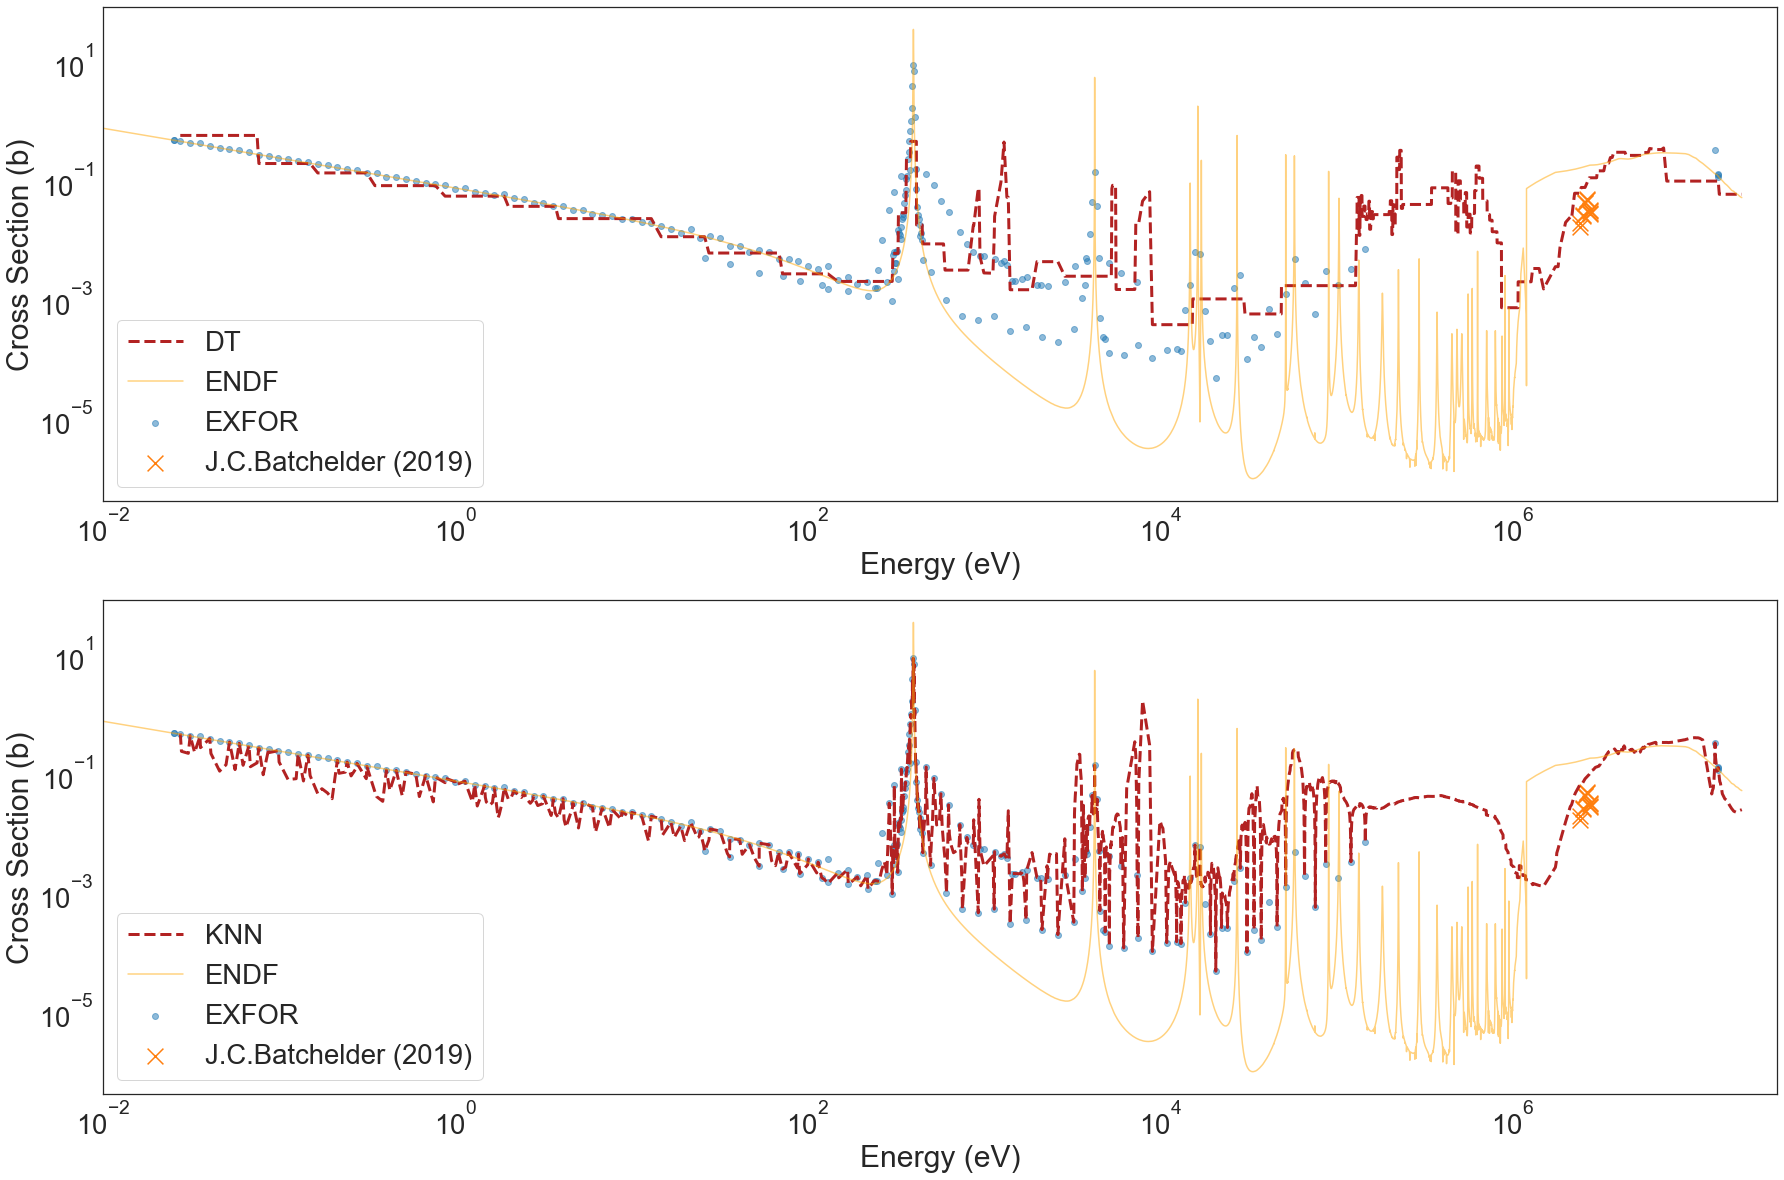

In [45]:
make_chlorine_paper_figure(df, dt_handpicked_model, dt_handpicked_scaler, knn_handpicked_model, knn_handpicked_scaler,
                           to_scale, endf_cl, ace_cl, saving_dir=figure_dir)

In [36]:
# unlog_chlorine = chlorine_35_np_dt.copy()
# unlog_chlorine["Energy"] = 10**chlorine_35_np_dt.Energy
# unlog_chlorine["Energy"] = unlog_chlorine["Energy"] * 10**-6

# unlog_df = df[df.MT_103 == 1].copy()
# unlog_df["Energy"] = 10**unlog_df.Energy
# unlog_df["Energy"] = unlog_df["Energy"] * 10**-6

# plt.figure(figsize=(14,10))
# sns.kdeplot(data=unlog_df, x="Energy", label="EXFOR (n,p)", fill=True)
# sns.kdeplot(data=unlog_chlorine, x="Energy", label="Chlorine-35 (n,p)", fill=True)
# plt.legend()
# plt.xlabel("Energy (MeV)")
# plt.savefig("bivariate_mt_103.png", dpi=600, bbox_inches="tight")

In [18]:
ml_grid = pd.read_csv("ML_GRID.csv")
u233_ml = pd.read_csv("U233_Data_ML.csv")

In [21]:
ml_grid

,Data_16,Data_17,Data_18,Data_37,Data_51,Data_52,Data_53,Data_54,Data_55,Data_56,...,Data_86,Data_87,Data_88,Data_91,Data_102,Data_4,Data_3,Data_101,Data_1,Data_2
0,0.000000,0.000000,26877.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2232.315000,0.000000,29109.835000,2232.315000,29157.207400,47.372400
1,0.000000,0.000000,25340.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2104.648000,0.000000,27445.008000,2104.648000,27489.828900,44.820900
2,0.000000,0.000000,24039.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1996.647000,0.000000,26036.617000,1996.647000,26079.287200,42.670200
3,0.000000,0.000000,22921.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1903.729000,0.000000,24824.939000,1903.729000,24865.765600,40.826600
4,0.000000,0.000000,21945.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1822.684000,0.000000,23768.074000,1822.684000,23807.298300,39.224300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8737,0.056734,0.045851,2.296800,0.149627,0.089681,0.039340,0.009014,0.000025,0.004165,0.000036,...,0.010878,0.010814,0.001975,0.062356,0.000155,0.257150,2.806318,0.000155,5.928545,3.122227
8738,0.055079,0.041571,2.296800,0.163561,0.089224,0.039059,0.008865,0.000024,0.004089,0.000036,...,0.010791,0.010729,0.001960,0.061695,0.000141,0.255056,2.812208,0.000141,5.881533,3.069325
8739,0.053518,0.037741,2.280800,0.176420,0.088789,0.038800,0.008731,0.000024,0.004018,0.000035,...,0.010690,0.010632,0.001942,0.061031,0.000130,0.252959,2.801567,0.000130,5.834610,3.033042
8740,0.052122,0.034419,2.214292,0.188032,0.088386,0.038567,0.008612,0.000024,0.003952,0.000035,...,0.010582,0.010529,0.001924,0.060303,0.000119,0.250845,2.739829,0.000119,5.788014,3.048185


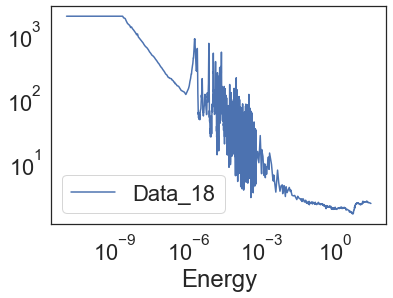

In [23]:
u233_ml.plot(x="Energy", y="Data_18")
plt.xscale('log')
plt.yscale('log')

In [23]:
exfor_mt1 = df[(df["Target_Protons"] == 92) & (df["MT_1"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt1.shape)
exfor_mt2 = df[(df["Target_Protons"] == 92) & (df["MT_2"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt2.shape)
exfor_mt3 = df[(df["Target_Protons"] == 92) & (df["MT_3"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt3.shape)
exfor_mt18 = df[(df["Target_Protons"] == 92) & (df["MT_18"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt18.shape)
exfor_mt101 = df[(df["Target_Protons"] == 92) & (df["MT_101"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt101.shape)
exfor_mt102 = df[(df["Target_Protons"] == 92) & (df["MT_102"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt102.shape)

exfor_mt1[to_scale] = scaler.transform(exfor_mt1[to_scale])
exfor_mt2[to_scale] = scaler.transform(exfor_mt2[to_scale])
exfor_mt3[to_scale] = scaler.transform(exfor_mt3[to_scale])
exfor_mt18[to_scale] = scaler.transform(exfor_mt18[to_scale])
exfor_mt101[to_scale] = scaler.transform(exfor_mt101[to_scale])
exfor_mt102[to_scale] = scaler.transform(exfor_mt102[to_scale])

print(mean_absolute_error(neigh_all.predict(exfor_mt1.drop(columns=["Data"])), exfor_mt1.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt2.drop(columns=["Data"])), exfor_mt2.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt3.drop(columns=["Data"])), exfor_mt3.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt18.drop(columns=["Data"])), exfor_mt18.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt101.drop(columns=["Data"])), exfor_mt101.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt102.drop(columns=["Data"])), exfor_mt102.Data))

(33384, 49)
(261, 49)
(2, 49)
(94567, 49)
(7, 49)
(4588, 49)
0.11498025492377936
0.029138092878862425
0.04549226696177883
0.06519720707800516
0.17749248625297656
0.16909921184572574


In [ ]:
def get_errors_for_mt(mt_list, df, Z, A, el):
    mae_results = pd.DataFrame(columns=['MT', 'MAE'])
    for mt in mt_list:
        endf_mt = nuc_data.load_endf(el + str(int(A)), mt, log=True)
        exfor_mt = df[(df["Target_Protons"] == Z) & (df["MT_1"] == 1) & (df["Target_Mass_Number"] == A)]
        exfor_mt[to_scale] = scaler.transform(exfor_mt[to_scale])
        mt_mae = mean_absolute_error(neigh_all.predict(exfor_mt.drop(columns=["Data"])), exfor_mt.Data)
        mae_results["MT"] = mt
        mae_results["MAE"] = mt_mae
    return mae_results

In [24]:
endf_mt1 = nuc_data.load_endf("U233", "MT001", log=True)
endf_mt2  = nuc_data.load_endf("U233", "MT002", log=True)
endf_mt3  = nuc_data.load_endf("U233", "MT003", log=True)
endf_mt18 = nuc_data.load_endf("U233", "MT018", log=True)
endf_mt101  = nuc_data.load_endf("U233", "MT101", log=True)
endf_mt102  = nuc_data.load_endf("U233", "MT102", log=True)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT001.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (12617, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT002.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (5590, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT003.endfb8.0
Convering MeV to eV...
Finish reading ENDF data with shape:  (33329, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT018.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (15345, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT101.endfb8.0
File does not exists.
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-M

In [35]:
def get_error_endf_new(endf, new_data):
    endf_copy = endf.copy()
    indexes = np.arange(len(endf), len(endf) + len(new_data))
    new_data.index = indexes
    energy_interest = new_data[["Energy"]]
    energy_interest["Data"] = np.nan
    endf_copy = endf_copy.append(energy_interest, ignore_index=False)
    endf_copy = endf_copy.sort_values(by=['Energy'])
    endf_copy["Data"] = endf_copy["Data"].interpolate()

    # Measuring metrics on predictions.
    print("NEW DATA: ENDF vs EXFOR:")
    print(mean_absolute_error(new_data[["Data"]], endf_copy[["Data"]].loc[indexes]))
    
    # print(endf_copy[["Data"]].loc[indexes])

In [37]:
get_error_endf_new(endf_mt1, exfor_mt1)
get_error_endf_new(endf_mt2, exfor_mt2)
get_error_endf_new(endf_mt3, exfor_mt3)
get_error_endf_new(endf_mt18, exfor_mt18)
get_error_endf_new(endf_mt102, exfor_mt102)

NEW DATA: ENDF vs EXFOR:
0.12225468523644997
NEW DATA: ENDF vs EXFOR:
0.06453464913682203
NEW DATA: ENDF vs EXFOR:
0.05256837778722229
NEW DATA: ENDF vs EXFOR:
0.09105713111655128
NEW DATA: ENDF vs EXFOR:
0.22099112919514152


In [ ]:
import plotly.graph_objects as go

# Nodes & links
nodes = [
    ['ID', 'Label', 'Color'],
    [0,'Experiment','#6eab38'],
    [1,'Compilation','#a9a9a9'],
    [2,'Evaluation','#cca5b7'],
    [3,'Processing','#faae82'],
    [4,'Validation','#1db0de'],
    [5,'Application','#989dd4'],
    
    [6, 'nucml.ace','#4C4231'],
    [7, 'nucml.ame','#4C4231'],
    [8, 'nucml.ensdf','#4C4231'],
    [9, 'nucml.evaluation','#4C4231'],
    [10, 'nucml.exfor','#4C4231'],
    [11, 'nucml.model','#4C4231'],
    [12, 'nucml.plot','#4C4231'],
    [13, 'nucml.datasets','#4C4231']
]

values = np.linspace(6,1,6).astype(int)
links = [['Source','Target','Value','Link Color'],

        # Experiment
        [0,8,values[0],'rgba(127, 194, 65, 0.2)'],
        [0,10,values[0],'rgba(127, 194, 65, 0.2)'],

        # Compilation
        [1,7,values[1],'rgba(211, 211, 211, 0.5)'],
        [1,8,values[1],'rgba(211, 211, 211, 0.5)'],
        [1,10,values[1],'rgba(211, 211, 211, 0.5)'],

        # Evaluation
        [2,11,values[2],'#FFD6E9'],
        [2,13,values[2],'#FFD6E9'],

        # Processing
        [3,6,values[3],'rgba(253, 227, 212, 1)'],
        [3,10,values[3],'rgba(253, 227, 212, 1)'],
        
        # Validation
        [4,6,values[4],'#9de4fa'],
        [4,10,values[4],'#9de4fa'],
        [4,11,values[4],'#9de4fa'],
        
        # Application
        [5,6,values[5],'#D6D9F9'],        
        ]

# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)

# Sankey plot setup
data_trace = dict(
    type='sankey',
    arrangement="snap",
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
        title = "Draw Sankey Diagram from dataframes",
    height = 800,
    width = 1400,
    font = dict(
      size = 20),)

fig = dict(data=[data_trace], layout=layout)
# iplot(fig, validate=False)

import plotly.io as pio
pio.renderers.default = 'browser'

figure = go.Figure(fig)

figure